# Teeth Disease Prediction

### 1 - Import Libraries & Load the Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
import os 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

In [3]:
# Dataset Paths
main_dir = 'Teeth_Dataset'

train_dir = os.path.join(main_dir, 'Training')
test_dir = os.path.join(main_dir, 'Testing')
val_dir = os.path.join(main_dir, 'Validation')

### 2 - Visualization

In [4]:

def count_images_per_class(dataset_dir, set_type):
    # Get class labels (subfolders)
    cls_labels = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    # Count images in each subfolder
    image_counts = {
        folder: len([
            f for f in os.listdir(os.path.join(dataset_dir, folder)) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        for folder in cls_labels
    }

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(f"Number of Images per Class in {set_type} Set")
    plt.xticks(rotation=45)
    plt.show()
    return image_counts

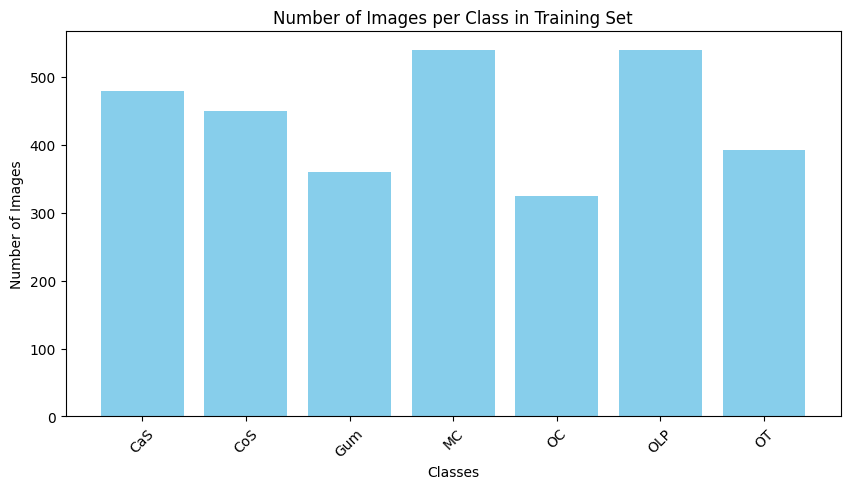

{'CaS': 480,
 'CoS': 450,
 'Gum': 360,
 'MC': 540,
 'OC': 324,
 'OLP': 540,
 'OT': 393}

In [5]:
count_images_per_class(train_dir, 'Training')       

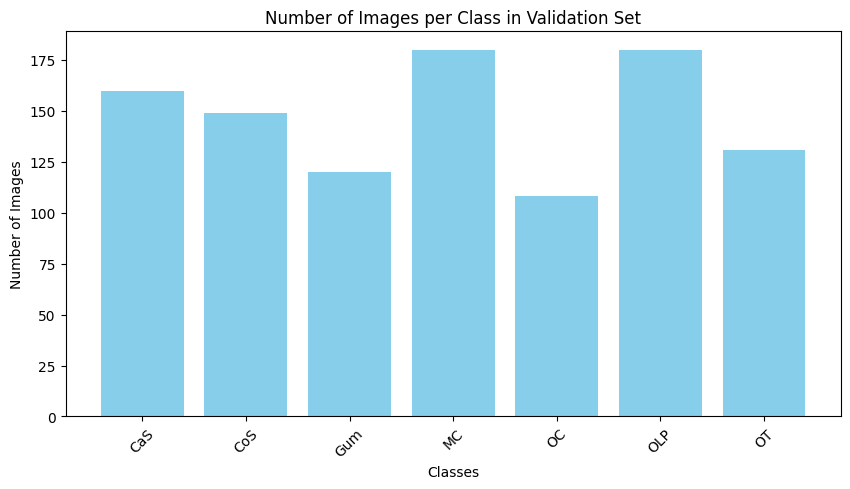

{'CaS': 160,
 'CoS': 149,
 'Gum': 120,
 'MC': 180,
 'OC': 108,
 'OLP': 180,
 'OT': 131}

In [6]:
count_images_per_class(val_dir, 'Validation')        

### 3- Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    fill_mode='nearest'  
)
val_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
# Define image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = IMG_SIZE, 
        batch_size=BATCH_SIZE,
        class_mode='categorical' 
)

val_generator = val_datagen.flow_from_directory(
        val_dir, 
        target_size = IMG_SIZE, 
        batch_size=BATCH_SIZE,
        class_mode='categorical' 
) 

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


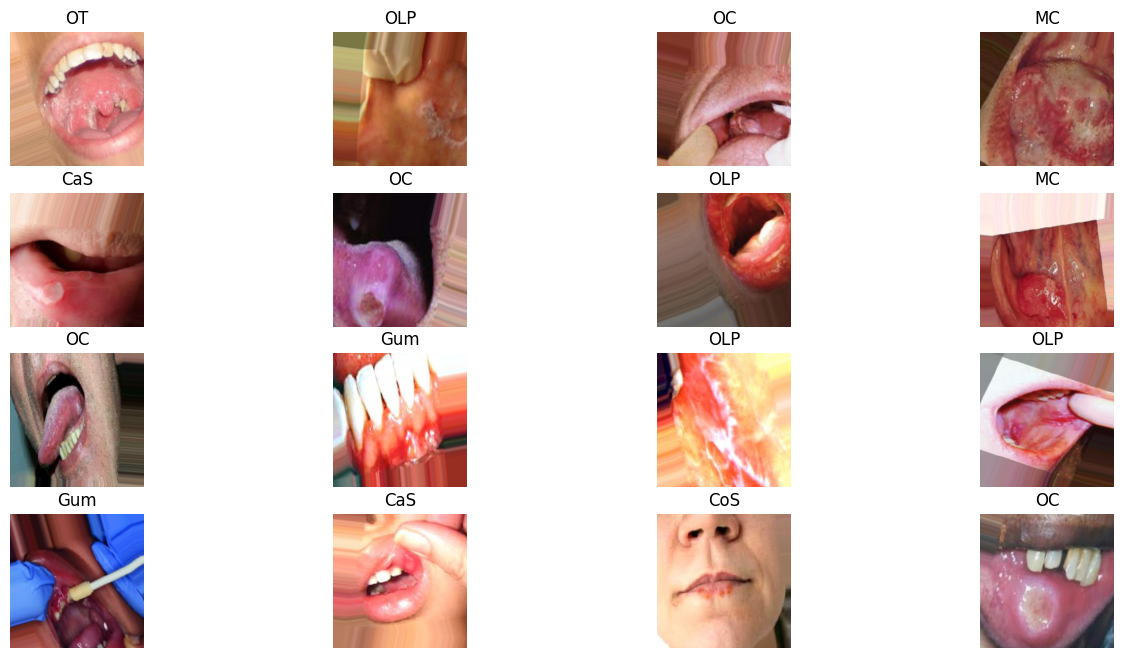

In [9]:
class_names = ['CaS', 'CoS', 'Gum','MC','OC','OLP','OT']

# Visualize Augmentation
def visualize_augmentation(generator):
    augmented_image, label = train_generator.next()
    plt.figure(figsize=(16,8))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

    plt.show()

visualize_augmentation(train_generator)

### 4- Model Architecture and Training


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') 
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from sklearn.utils.class_weight import compute_class_weight  
import numpy as np  

class_weights = compute_class_weight('balanced', classes=np.arange(7), y= train_generator.classes)  
class_weights = dict(enumerate(class_weights))  

In [12]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification_best_model.h5',       
    monitor='val_loss',     
    save_best_only=True,    
    save_weights_only=True  
)

In [14]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=10,          
    restore_best_weights=True 
)

In [15]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100, class_weight=class_weights, callbacks=[checkpoint, early_stopping])

Epoch 1/100
97/97 [==============================] - 90s 919ms/step - loss: 1.9449 - accuracy: 0.1892 - val_loss: 1.7680 - val_accuracy: 0.3025
Epoch 2/100
97/97 [==============================] - 89s 914ms/step - loss: 1.8138 - accuracy: 0.2650 - val_loss: 1.6963 - val_accuracy: 0.3424
Epoch 3/100
97/97 [==============================] - 88s 911ms/step - loss: 1.7076 - accuracy: 0.3197 - val_loss: 1.5680 - val_accuracy: 0.4037
Epoch 4/100
97/97 [==============================] - 89s 914ms/step - loss: 1.6419 - accuracy: 0.3320 - val_loss: 1.4673 - val_accuracy: 0.4426
Epoch 5/100
97/97 [==============================] - 89s 915ms/step - loss: 1.6415 - accuracy: 0.3372 - val_loss: 1.4873 - val_accuracy: 0.4319
Epoch 6/100
97/97 [==============================] - 88s 911ms/step - loss: 1.5918 - accuracy: 0.3683 - val_loss: 1.3821 - val_accuracy: 0.4874
Epoch 7/100
97/97 [==============================] - 88s 907ms/step - loss: 1.5245 - accuracy: 0.4075 - val_loss: 1.3919 - val_accuracy:

In [16]:
# function to plot accuracy and loss

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
               
    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

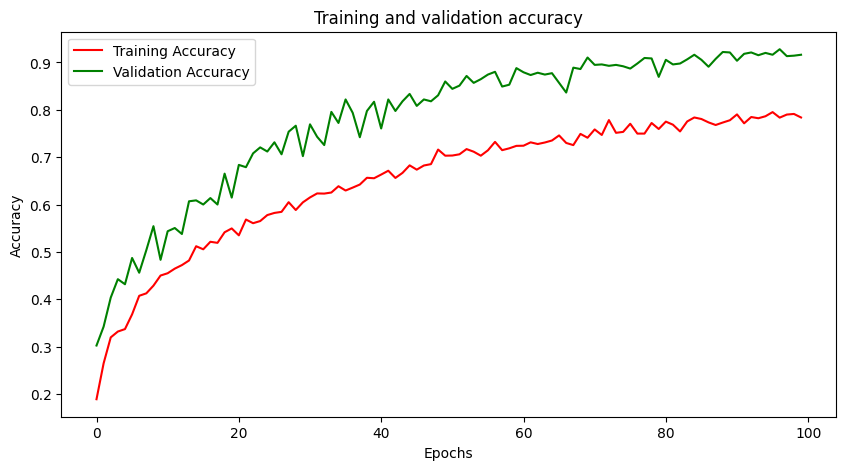

<Figure size 640x480 with 0 Axes>

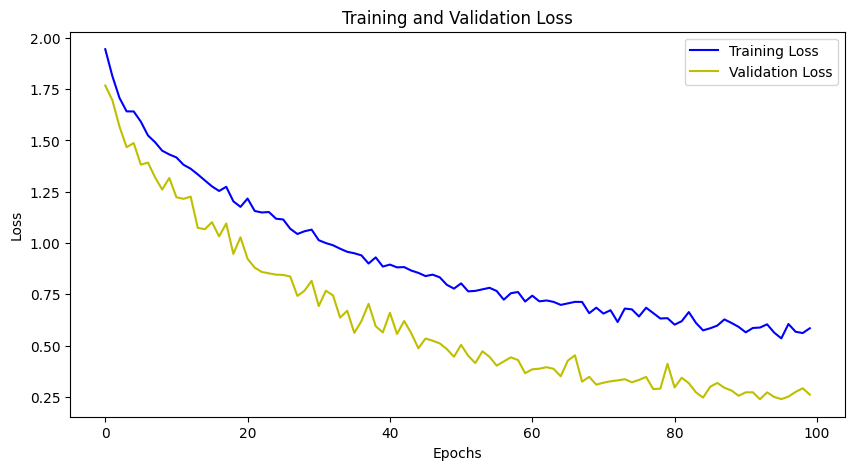

In [17]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

### 5- Model Evaluation

In [18]:
# Save the model
model.save('teeth_classification_model.h5')

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#load model
model = load_model('teeth_classification_model.h5')
#evaluate model
test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator= test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Found 1028 images belonging to 7 classes.
33/33 [==============================] - 17s 505ms/step - loss: 0.2210 - accuracy: 0.9377
Test loss: 0.2209997922182083
Test accuracy: 0.9377431869506836
